In [1]:
%load_ext autoreload
%autoreload 2

### Basic Imports

In [2]:
import nbimporter
from typing import Dict, Tuple, List
import numpy as np
from tqdm import tqdm

### Env Vars

In [3]:
QUBITS_NUM = 4 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

### Simulator Backend

In [4]:
from qiskit import Aer
from qiskit.utils import QuantumInstance, algorithm_globals

seed = 50
algorithm_globals.random_seed = seed

simulator_backend = Aer.get_backend('qasm_simulator')

### BFGS Optimizer

In [5]:
from scipy.optimize import minimize

### Ansatz State

In [6]:
from linear_entangelment_and_full_entangelment_ansatz_circuits import *

In [7]:
def get_ansatz_state(thetas, ansatz_entangelment, input_state):
    if ansatz_entangelment=="full":
        return get_full_entangelment_ansatz(QUBITS_NUM, thetas, input_state)
    if ansatz_entangelment=="linear":
        return get_linear_entangelment_ansatz(QUBITS_NUM, thetas, input_state)

## Expectation Value

### convert hamiltonian to pauli strings

In [8]:
def transfrom_hamiltonian_into_pauli_strings(hamiltonian) -> List:
    pauli_operators = hamiltonian.to_pauli_op().settings['oplist']
    pauli_coeffs = list(map(lambda pauli_operator: pauli_operator.coeff, pauli_operators))
    pauli_strings = list(map(lambda pauli_operator: pauli_operator.primitive, pauli_operators))
    return pauli_coeffs, pauli_strings

### pauli string reduction to sigma_z's

In [9]:
from qiskit.circuit.library.standard_gates import HGate, SGate
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

In [10]:
reducing_to_pauli_z_mapping = {
    'I': 'I',
    'Z': 'Z',
    'X': 'Z',
    'Y': 'Z'
} 

In [11]:
def reduce_pauli_matrixes_into_sigma_z(pauli_string) -> str:
    reduced_pauli_string = ""
    for matrix_index in range(QUBITS_NUM):
        pauli_matrix = str(pauli_string[matrix_index])
        reduced_pauli_matrix = reducing_to_pauli_z_mapping[pauli_matrix]
        reduced_pauli_string = reduced_pauli_matrix + reduced_pauli_string
    
    return reduced_pauli_string

In [12]:
def add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string, quantum_circuit):
    quantum_registers = QuantumRegister(QUBITS_NUM, name="qubit")
    additional_circuit_layer = QuantumCircuit(quantum_registers)
    
    for quantum_register_index, pauli_matrix in enumerate(pauli_string):
        if pauli_matrix == "X":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
        if pauli_string == "Y":
            additional_circuit_layer.append(HGate(), [quantum_registers[quantum_register_index]])
            additional_circuit_layer.append(SGate(), [quantum_registers[quantum_register_index]])
                
    extended_quantum_circuit = quantum_circuit.compose(additional_circuit_layer)
    return extended_quantum_circuit

### probabilities distribution

In [13]:
def get_probability_distribution(counts: Dict) -> Dict:
    proba_distribution = {state: (count / NUM_SHOTS) for state, count in counts.items()}
    return proba_distribution

def calculate_probabilities_of_measurments_in_computational_basis(quantum_state_circuit) -> Dict:
    quantum_state_circuit.measure_all()
    
    transpiled_quantum_state_circuit = transpile(quantum_state_circuit, simulator_backend) 
    Qobj = assemble(transpiled_quantum_state_circuit)
    result = simulator_backend.run(Qobj).result()
    counts = result.get_counts(quantum_state_circuit)
    
    return get_probability_distribution(counts)

### Expectation value from probabilities

In [14]:
def sort_probas_dict_by_qubits_string_keys(proba_distribution: Dict) -> Dict:
    return dict(sorted(proba_distribution.items()))

def reset_power_of_minus_1(power_of_minus_1):
    power_of_minus_1 = 0
    return power_of_minus_1

def convert_pauli_string_into_str(pauli_string) -> str:
    return str(pauli_string)

def calculate_expectation_value_of_pauli_string_by_measurments_probas(pauli_string, ansatz_circuit):
    pauli_string_expectation_value = 0
    power_of_minus_1 = 0
    
    pauli_string_str = convert_pauli_string_into_str(pauli_string)
    extended_ansatz_circuit = add_layer_of_gates_for_reducing_paulis_to_sigma_z(pauli_string_str, ansatz_circuit)
    probas_distribution = calculate_probabilities_of_measurments_in_computational_basis(extended_ansatz_circuit)
    
    reduced_pauli_string = reduce_pauli_matrixes_into_sigma_z(pauli_string)
    sorted_probas_distribuition = sort_probas_dict_by_qubits_string_keys(probas_distribution)
    for qubits_string, proba in sorted_probas_distribuition.items():
        for string_index in range(QUBITS_NUM):
            if(str(qubits_string[string_index])=="1" and str(pauli_string[string_index])=="Z"):
                power_of_minus_1 += 1
            
        pauli_string_expectation_value += pow(-1, power_of_minus_1)*proba
        power_of_minus_1 = reset_power_of_minus_1(power_of_minus_1)
        
    return pauli_string_expectation_value

In [15]:
def get_expectation_value(ansatz_circuit, pauli_coeffs, pauli_strings):
    total_expection_value = 0
    
    for pauli_coeff, pauli_string in tqdm(zip(pauli_coeffs, pauli_strings)):
        total_expection_value += pauli_coeff*calculate_expectation_value_of_pauli_string_by_measurments_probas(
                                                                                    pauli_string, ansatz_circuit)
    
    return total_expection_value

## Objective Function

In [16]:
from qiskit import assemble, transpile

def cost_function(thetas, hamiltonian, ansatz_entangelment):
    initial_eigenvector = np.identity(N)[0]
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    ansatz_state = get_ansatz_state(thetas, ansatz_entangelment, initial_eigenvector)
        
    L = get_expectation_value(ansatz_state, pauli_coeffs, pauli_strings)
    insert_approximated_energy_to_list_of_all_approximated_energies(L)
        
    return L

## Optimization

In [17]:
def get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment):
    initial_thetas = np.random.uniform(low=0, high=2*np.pi, size=PARAMS_NUM)
    optimizer_result = minimize(cost_function,
                                x0=initial_thetas,
                                args=(hamiltonian, ansatz_entangelment),
                                method="COBYLA",
                                options={"maxiter":NUM_ITERATIONS,
                                        "disp": True})
    optimal_thetas = optimizer_result.x
    
    return optimal_thetas

In [18]:
def get_approximated_eigenvalue_of_hamiltonian(hamiltonian, ansatz_entangelment):
    optimal_thetas = get_optimal_thetas_of_ansatz_circuit_for_hamiltonian(hamiltonian, ansatz_entangelment)
    print(optimal_thetas)
    initial_eigenvector = np.identity(N)[0]
    optimal_ansatz_state = get_ansatz_state(optimal_thetas, ansatz_entangelment, initial_eigenvector)
    
    pauli_coeffs, pauli_strings = transfrom_hamiltonian_into_pauli_strings(hamiltonian)
    approximated_eigenvalue = get_expectation_value(optimal_ansatz_state, pauli_coeffs, pauli_strings)

    return approximated_eigenvalue

## Comparsion

In [19]:
from numpy import linalg as LA

def get_approximation_error(exact_eigenvalue, approximated_eigenvalue):
    return abs(abs(exact_eigenvalue)-abs(approximated_eigenvalue))/abs(exact_eigenvalue)

In [20]:
def get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian):
    eigen_values = LA.eigvals(hamiltonian.to_matrix())
    print(sorted(eigen_values))
    
    return min(sorted(eigen_values))

In [21]:
def compare_exact_and_approximated_eigenvalue(hamiltonian, approximated_eigenvalue):
    exact_eigenvalue = get_minimum_exact_eigenvalue_of_hamiltonian(hamiltonian)
    print("Exact Eigenvalue:")
    print(exact_eigenvalue)
    print("\nApproximated Eigenvalue:")
    print(approximated_eigenvalue)

    print("\nApproximation Error")
    print(get_approximation_error(exact_eigenvalue, approximated_eigenvalue))
    
    plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin=3)
    initialize_approximated_energy_to_list_of_all_approximated_energies()

## Visualization

In [22]:
approximated_energies = []

In [23]:
def insert_approximated_energy_to_list_of_all_approximated_energies(energy):
    approximated_energies.append(energy)

In [24]:
def initialize_approximated_energy_to_list_of_all_approximated_energies():
    approximated_energies = []

In [25]:
import matplotlib.pyplot as plt

def plot_convergence_of_optimization_process(approximated_energies, exact_eigenvalue, margin):
    plt.title("convergence of optimization process to the exact eigenvalue")
    plt.margins(0, margin)
    plt.plot(approximated_energies)
    plt.axhline(y = exact_eigenvalue, color = 'r', linestyle = '-')
    plt.grid()
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")
    
def plot_fidelity():
    plt.plot(LiH_approximated_energies)
    plt.xlabel("# of iterations")
    plt.ylabel("Energy")

## LiH Molecule 4 qubits

In [26]:
from qiskit.opflow import X, Z, I, H, Y

LiH_molecule_4_qubits = -7.49894690201071*(I^I^I^I) + \
                            -0.0029329964409502266*(X^X^Y^Y) + \
                            0.0029329964409502266*(X^Y^Y^X) + \
                            0.01291078027311749*(X^Z^X^I) + \
                            -0.0013743761078958677*(X^Z^X^Z) + \
                            0.011536413200774975*(X^I^X^I) + \
                            0.0029329964409502266*(Y^X^X^Y) + \
                            -0.0029329964409502266*(Y^Y^X^X) + \
                            0.01291078027311749*(Y^Z^Y^I) + \
                            -0.0013743761078958677*(Y^Z^Y^Z) + \
                            0.011536413200774975*(Y^I^Y^I) + \
                            0.16199475388004184*(Z^I^I^I) + \
                            0.011536413200774975*(Z^X^Z^X) + \
                            0.011536413200774975*(Z^Y^Z^Y) + \
                            0.12444770133137588*(Z^Z^I^I) + \
                            0.054130445793298836*(Z^I^Z^I) + \
                            0.05706344223424907*(Z^I^I^Z) + \
                            0.012910780273117487*(I^X^Z^X) + \
                            -0.0013743761078958677*(I^X^I^X) + \
                            0.012910780273117487*(I^Y^Z^Y) + \
                            -0.0013743761078958677*(I^Y^I^Y) + \
                            0.16199475388004186*(I^Z^I^I) + \
                            0.05706344223424907*(I^Z^Z^I) + \
                            0.054130445793298836*(I^Z^I^Z) + \
                            -0.013243698330265966*(I^I^Z^I) + \
                            0.08479609543670981*(I^I^Z^Z) + \
                            -0.013243698330265952*(I^I^I^Z)

#### Linear Entangelment

In [27]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "linear")

27it [00:03,  6.87it/s]
27it [00:02,  9.64it/s]
27it [00:02, 10.49it/s]
27it [00:02, 10.14it/s]
27it [00:02,  9.75it/s]
27it [00:02, 10.11it/s]
27it [00:02, 10.02it/s]
27it [00:02, 10.02it/s]
27it [00:02, 10.24it/s]
27it [00:02,  9.79it/s]
27it [00:02,  9.93it/s]
27it [00:02, 10.25it/s]
27it [00:02,  9.94it/s]
27it [00:02, 10.11it/s]
27it [00:02,  9.96it/s]
27it [00:02,  9.70it/s]
27it [00:02, 10.00it/s]
27it [00:02,  9.88it/s]
27it [00:02, 10.00it/s]
27it [00:02, 10.18it/s]
27it [00:02, 10.36it/s]
27it [00:02,  9.84it/s]
27it [00:02, 10.09it/s]
27it [00:02,  9.95it/s]
27it [00:02, 10.24it/s]
27it [00:02, 10.06it/s]
27it [00:02, 10.13it/s]
27it [00:02, 10.68it/s]
27it [00:02, 10.17it/s]
27it [00:02,  9.88it/s]
27it [00:02, 10.32it/s]
27it [00:02, 10.42it/s]
27it [00:02, 10.03it/s]
27it [00:02, 10.12it/s]
27it [00:02, 10.00it/s]
27it [00:02,  9.84it/s]
27it [00:02, 10.32it/s]
27it [00:02, 10.35it/s]
27it [00:02, 10.40it/s]
27it [00:02, 10.25it/s]
27it [00:02, 10.21it/s]
27it [00:02, 10.

[ 3.19047961  3.65603467  3.40111649  6.36658713  3.34324313  3.39784071
  5.29568815  4.3010533   3.11248219  6.67566463  3.73714972  4.28982545
  0.88963439  1.52146056  0.01435158  5.70777578  2.9116771   2.51592583
  5.27152279  0.81087113  2.60730817  7.11522015  4.16341213  0.56224664
 -0.08141214  2.93091515  6.01175739  4.32707898  5.52564049  5.24155328
  3.4912888   4.96610342]


27it [00:02, 10.05it/s]

CPU times: total: 4min 18s
Wall time: 4min 30s


### Comparsion between approximate value after optimtimzation and exact eigenvalue

[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.799125134980942

Approximation Error
0.008094857466615027


C:\Users\hadar\anaconda3\envs\Qiskitenv\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


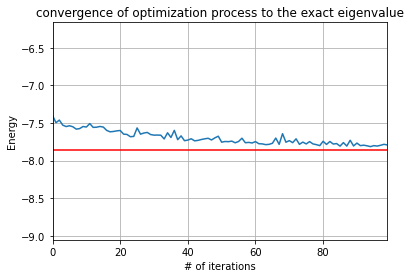

In [28]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

#### Full Entangelment

In [29]:
%%time
LiH_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(LiH_molecule_4_qubits, "full")

27it [00:02,  9.59it/s]
27it [00:02,  9.65it/s]
27it [00:02,  9.66it/s]
27it [00:02,  9.67it/s]
27it [00:02,  9.39it/s]
27it [00:02,  9.70it/s]
27it [00:02,  9.52it/s]
27it [00:02,  9.53it/s]
27it [00:02,  9.42it/s]
27it [00:02,  9.46it/s]
27it [00:02,  9.49it/s]
27it [00:02,  9.13it/s]
27it [00:02,  9.86it/s]
27it [00:02,  9.88it/s]
27it [00:02,  9.50it/s]
27it [00:02,  9.70it/s]
27it [00:02,  9.39it/s]
27it [00:02,  9.33it/s]
27it [00:02,  9.83it/s]
27it [00:02,  9.62it/s]
27it [00:02,  9.80it/s]
27it [00:02,  9.66it/s]
27it [00:02,  9.12it/s]
27it [00:02,  9.62it/s]
27it [00:02,  9.56it/s]
27it [00:02,  9.67it/s]
27it [00:02,  9.70it/s]
27it [00:02,  9.66it/s]
27it [00:02,  9.15it/s]
27it [00:02,  9.52it/s]
27it [00:02,  9.68it/s]
27it [00:02,  9.44it/s]
27it [00:02,  9.84it/s]
27it [00:02,  9.64it/s]
27it [00:02,  9.35it/s]
27it [00:02,  9.33it/s]
27it [00:02,  9.56it/s]
27it [00:02,  9.71it/s]
27it [00:02,  9.62it/s]
27it [00:03,  8.84it/s]
27it [00:02,  9.00it/s]
27it [00:02,  9.

[5.32988988 4.61164735 5.41137437 4.11991268 1.92270237 5.54568379
 2.88338939 1.61262983 3.48684646 2.55185062 0.81489403 3.04166451
 4.20637973 1.54498223 4.95430037 4.73524678 0.04437719 2.380946
 0.76839718 6.94465007 5.58709692 2.3834855  2.20294415 2.26901887
 1.014337   2.41514238 5.80527217 3.61048759 3.52962115 2.34775618
 4.14434952 6.00609571]


27it [00:02,  9.18it/s]

CPU times: total: 4min 32s
Wall time: 4min 41s


[(-7.862773163027979+0j), (-7.7833962082865185+0j), (-7.783396208286518+0j), (-7.7140566916607005+0j), (-7.714056691660695+0j), (-7.714056691660695+0j), (-7.700475837803976+0j), (-7.569984737620559+0j), (-7.569984737620559+0j), (-7.511999706834453+0j), (-7.511999706834451+0j), (-7.364817440287081+0j), (-7.151525481896562+0j), (-7.130406955301309+0j), (-7.130406955301308+0j), (-6.769813218087976+0j)]
Exact Eigenvalue:
(-7.862773163027979+0j)

Approximated Eigenvalue:
-7.764937530966622

Approximation Error
0.012442891335260154


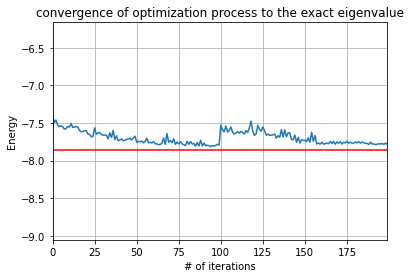

In [30]:
compare_exact_and_approximated_eigenvalue(LiH_molecule_4_qubits, LiH_approximated_eigenvalue)

## H2 Molecule 4 qubits

In [31]:
H2_molecule_Hamiltonian_4_qubits =  -0.8105479805373279 * (I^I^I^I) \
                                    + 0.1721839326191554 * (I^I^I^Z) \
                                    - 0.22575349222402372 * (I^I^Z^I) \
                                    + 0.17218393261915543 * (I^Z^I^I) \
                                    - 0.2257534922240237 * (Z^I^I^I) \
                                    + 0.12091263261776627 * (I^I^Z^Z) \
                                    + 0.16892753870087907 * (I^Z^I^Z) \
                                    + 0.045232799946057826 * (Y^Y^Y^Y) \
                                    + 0.045232799946057826 * (X^X^Y^Y) \
                                    + 0.045232799946057826 * (Y^Y^X^X) \
                                    + 0.045232799946057826 * (X^X^X^X) \
                                    + 0.1661454325638241 * (Z^I^I^Z) \
                                    + 0.1661454325638241 * (I^Z^Z^I) \
                                    + 0.17464343068300453 * (Z^I^Z^I) \
                                    + 0.12091263261776627 * (Z^Z^I^I)

#### Linear Entangelment

In [32]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "linear")

15it [00:01,  9.74it/s]
15it [00:01,  9.68it/s]
15it [00:01,  9.64it/s]
15it [00:01,  9.62it/s]
15it [00:01,  9.67it/s]
15it [00:01,  9.30it/s]
15it [00:01,  9.69it/s]
15it [00:01,  9.92it/s]
15it [00:01,  9.68it/s]
15it [00:01,  9.53it/s]
15it [00:01,  9.52it/s]
15it [00:01,  9.90it/s]
15it [00:01,  9.65it/s]
15it [00:01,  9.56it/s]
15it [00:01,  9.92it/s]
15it [00:01,  9.77it/s]
15it [00:01,  9.43it/s]
15it [00:01,  9.89it/s]
15it [00:01,  9.72it/s]
15it [00:01, 10.01it/s]
15it [00:01,  9.83it/s]
15it [00:01,  9.58it/s]
15it [00:01, 10.03it/s]
15it [00:01,  9.81it/s]
15it [00:01,  9.89it/s]
15it [00:01,  9.96it/s]
15it [00:01,  9.86it/s]
15it [00:01,  9.62it/s]
15it [00:01,  9.57it/s]
15it [00:01,  9.94it/s]
15it [00:01,  9.43it/s]
15it [00:01, 10.01it/s]
15it [00:01,  9.72it/s]
15it [00:01,  9.68it/s]
15it [00:01,  9.71it/s]
15it [00:01, 10.00it/s]
15it [00:01,  9.72it/s]
15it [00:01,  9.60it/s]
15it [00:01,  9.33it/s]
15it [00:01,  9.86it/s]
15it [00:01,  9.23it/s]
15it [00:01,  9.

[ 3.91667992  5.71998499  6.28145125  1.28250965  2.67330372  0.48665177
  6.04710273 -0.15898566  2.98133627  4.38815837  0.42701909  5.94837479
  5.50772973  5.93838165  2.14131526  6.19129504  2.68102594  2.48239923
  6.75468904  5.59219419  2.31138436  0.81247086  4.86425768  6.9499901
  2.37318327  4.17876435  3.12141662  1.04935046  5.91042917  5.96907079
  2.79342359  4.41904811]


15it [00:01, 10.05it/s]

CPU times: total: 2min 31s
Wall time: 2min 37s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.4625089493354433

Approximation Error
0.21255122394227205


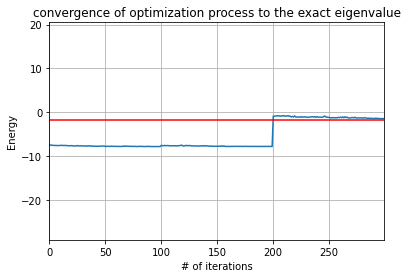

In [33]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [34]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_4_qubits, "full")

15it [00:01, 10.19it/s]
15it [00:01, 10.25it/s]
15it [00:01,  9.96it/s]
15it [00:01,  9.73it/s]
15it [00:01,  9.97it/s]
15it [00:01, 10.11it/s]
15it [00:01,  9.93it/s]
15it [00:01,  9.11it/s]
15it [00:01, 10.08it/s]
15it [00:01,  9.98it/s]
15it [00:01, 10.17it/s]
15it [00:01, 10.27it/s]
15it [00:01, 10.11it/s]
15it [00:01,  9.95it/s]
15it [00:01,  9.50it/s]
15it [00:01, 10.09it/s]
15it [00:01, 10.04it/s]
15it [00:01,  9.60it/s]
15it [00:01,  9.25it/s]
15it [00:01, 10.16it/s]
15it [00:01,  9.86it/s]
15it [00:01, 10.07it/s]
15it [00:01,  9.60it/s]
15it [00:01, 10.01it/s]
15it [00:01, 10.30it/s]
15it [00:01,  9.69it/s]
15it [00:01, 10.02it/s]
15it [00:01, 10.33it/s]
15it [00:01,  9.27it/s]
15it [00:01, 10.10it/s]
15it [00:01, 10.24it/s]
15it [00:01,  9.88it/s]
15it [00:01,  9.48it/s]
15it [00:01, 10.18it/s]
15it [00:01, 10.39it/s]
15it [00:01,  9.94it/s]
15it [00:01, 10.36it/s]
15it [00:01,  9.89it/s]
15it [00:01,  9.19it/s]
15it [00:01, 10.17it/s]
15it [00:01, 10.29it/s]
15it [00:01, 10.

[5.7340042  6.0343947  1.73997274 0.98361388 2.83435055 4.97862806
 6.36070248 4.53743944 2.99567776 2.10353293 1.57797741 5.06383028
 1.23711074 6.09921389 2.45905865 1.17830787 3.09265591 4.30325719
 3.88011176 1.63436014 6.64322063 2.25846599 2.80709292 2.96322343
 0.4578404  5.79419902 0.87082826 1.25819047 1.88268244 3.88073503
 3.55467175 0.70164906]


15it [00:01, 10.11it/s]

CPU times: total: 2min 28s
Wall time: 2min 33s


[(-1.8572750302023793+0j), (-1.25633907300325+0j), (-1.2563390730032498+0j), (-1.2445845498133272+0j), (-1.2445845498133272+0j), (-1.244584549813327+0j), (-1.1606317377577642+0j), (-1.1606317377577642+0j), (-0.8827221502448648+0j), (-0.47189600728114256+0j), (-0.47189600728114245+0j), (-0.353325104107155+0j), (-0.353325104107155+0j), (-0.2249112528308709+0j), (-1.942890293094024e-16+0j), (0.2142782384194731+0j)]
Exact Eigenvalue:
(-1.8572750302023793+0j)

Approximated Eigenvalue:
-1.5669491927149528

Approximation Error
0.15631817192728364


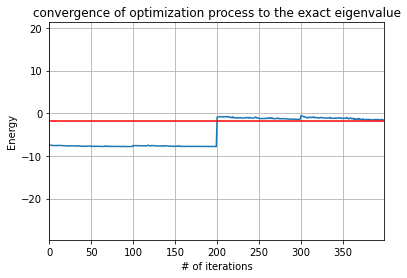

In [35]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_4_qubits, H2_approximated_eigenvalue)

##  Transverse Ising Model 4 qubits

In [36]:
transverse_ising_4_qubits = 0.0 * (I^I^I^I) \
    + 0.8398088405253477 * (X^I^I^I) \
    + 0.7989496312070936 * (I^X^I^I) \
    + 0.38189710487113193 * (Z^Z^I^I) \
    + 0.057753122422666725 * (I^I^X^I) \
    + 0.5633292636970458 * (Z^I^Z^I) \
    + 0.3152740621483513 * (I^Z^Z^I) \
    + 0.07209487981989715 * (I^I^I^X) \
    + 0.17892334004292654 * (Z^I^I^Z) \
    + 0.2273896497668042 * (I^Z^I^Z) \
    + 0.09762902934216211 * (I^I^Z^Z)

#### Linear Entangelment

In [37]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "linear")

11it [00:01, 10.86it/s]
11it [00:01, 10.30it/s]
11it [00:01, 10.53it/s]
11it [00:01, 10.00it/s]
11it [00:01,  9.73it/s]
11it [00:01,  9.07it/s]
11it [00:01,  9.69it/s]
11it [00:01, 10.32it/s]
11it [00:01,  8.71it/s]
11it [00:01,  8.47it/s]
11it [00:01, 10.47it/s]
11it [00:01,  9.48it/s]
11it [00:01, 10.51it/s]
11it [00:01,  9.54it/s]
11it [00:01, 10.16it/s]
11it [00:01, 10.07it/s]
11it [00:01,  9.80it/s]
11it [00:01, 10.44it/s]
11it [00:01, 10.06it/s]
11it [00:01, 10.14it/s]
11it [00:01, 10.68it/s]
11it [00:01,  9.43it/s]
11it [00:01, 10.62it/s]
11it [00:01, 10.20it/s]
11it [00:01, 10.22it/s]
11it [00:01, 10.14it/s]
11it [00:01, 10.38it/s]
11it [00:01, 10.69it/s]
11it [00:01,  9.98it/s]
11it [00:01,  8.53it/s]
11it [00:01,  9.80it/s]
11it [00:01, 10.70it/s]
11it [00:01,  9.95it/s]
11it [00:01,  9.10it/s]
11it [00:01,  8.48it/s]
11it [00:01,  8.58it/s]
11it [00:01,  9.45it/s]
11it [00:00, 11.32it/s]
11it [00:01, 10.40it/s]
11it [00:01, 10.09it/s]
11it [00:01, 10.55it/s]
11it [00:01,  9.

[2.67703456 1.22762107 3.66392423 3.71289285 1.56976529 6.8043031
 4.97553947 0.02553571 4.10561009 1.93539927 2.62660475 0.34547598
 6.28953648 7.03993893 5.82799522 2.4926338  2.1553386  4.57358536
 3.93374906 5.17473376 2.63910846 1.01806368 5.55288185 1.2886814
 4.43238345 3.80900439 3.20467782 0.21514683 5.64128796 4.86495211
 3.20343343 0.76679055]


11it [00:01,  9.63it/s]

CPU times: total: 1min 47s
Wall time: 3min 54s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
1.2353010534151896

Approximation Error
0.3821905665383319


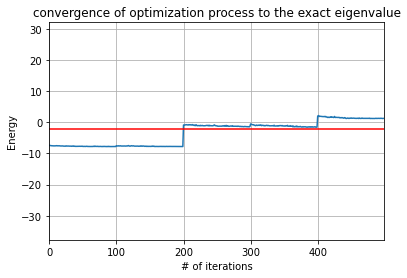

In [38]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [39]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_4_qubits, "full")

11it [00:01,  9.65it/s]
11it [00:01,  9.93it/s]
11it [00:01, 10.03it/s]
11it [00:01, 10.04it/s]
11it [00:01,  9.85it/s]
11it [00:01, 10.30it/s]
11it [00:01,  9.78it/s]
11it [00:01,  9.82it/s]
11it [00:01, 10.44it/s]
11it [00:01,  9.59it/s]
11it [00:01, 10.82it/s]
11it [00:01,  9.71it/s]
11it [00:01, 10.46it/s]
11it [00:01,  9.14it/s]
11it [00:01,  9.69it/s]
11it [00:01, 10.21it/s]
11it [00:01,  9.94it/s]
11it [00:01,  9.09it/s]
11it [00:01, 10.31it/s]
11it [00:01,  9.69it/s]
11it [00:01,  9.84it/s]
11it [00:01, 10.57it/s]
11it [00:01,  9.89it/s]
11it [00:01, 10.32it/s]
11it [00:01,  9.93it/s]
11it [00:01, 10.48it/s]
11it [00:01,  9.97it/s]
11it [00:01,  9.80it/s]
11it [00:01, 10.66it/s]
11it [00:01,  9.92it/s]
11it [00:01,  9.78it/s]
11it [00:01,  8.91it/s]
11it [00:01,  9.54it/s]
11it [00:01, 10.35it/s]
11it [00:01, 10.11it/s]
11it [00:01, 10.39it/s]
11it [00:01,  9.59it/s]
11it [00:01, 10.26it/s]
11it [00:01,  9.98it/s]
11it [00:01, 10.00it/s]
11it [00:01, 10.19it/s]
11it [00:01, 10.

[ 5.42286162  6.34682506  4.56225915  1.97944491  1.45026573  4.66701976
  3.57039168  6.74198239  3.0409327   3.62953544  2.23565365  3.99132881
  1.95577031  5.91940649  4.85333419  2.9162605   2.82843951  3.48762378
  3.15607883  5.81673425  4.47755191  2.38966318  2.32578157 -0.198807
 -0.39726732  3.32291814  2.04770937  1.91394592  2.99830676  6.10382976
  3.59777579  3.77374194]


11it [00:01,  9.93it/s]

CPU times: total: 1min 49s
Wall time: 1min 52s


[(-1.9994855800333675+0j), (-1.9080638482930956+0j), (-1.8497137109270194+0j), (-1.7583827504312988+0j), (-0.5462047134056278+0j), (-0.47710503946487287+0j), (-0.31907768442618767+0j), (-0.2505930484227001+0j), (0.14239915569453057+0j), (0.20992649961322052+0j), (0.2757654176709828+0j), (0.3444947223438019+0j), (1.6816520928402046+0j), (1.6958488386667439+0j), (2.3718326043433704+0j), (2.3867070442313216+0j)]
Exact Eigenvalue:
(-1.9994855800333675+0j)

Approximated Eigenvalue:
1.1125465522100408

Approximation Error
0.4435836080440877


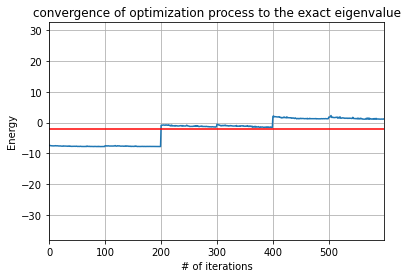

In [40]:
compare_exact_and_approximated_eigenvalue(transverse_ising_4_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 3 qubits

In [41]:
QUBITS_NUM = 3 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [42]:
from qiskit.opflow import X, Z, I

transverse_ising_3_qubits = 0.0 * (I^I^I) \
                    + 0.012764169333459807 * (X^I^I) \
                    + 0.7691573729160869 * (I^X^I) \
                    + 0.398094746026449 * (Z^Z^I) \
                    + 0.15250261906586637 * (I^I^X) \
                    + 0.2094051920882264 * (Z^I^Z) \
                    + 0.5131291860752999 * (I^Z^Z)

#### Linear Entangelment

In [43]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "linear")

7it [00:00, 12.74it/s]
7it [00:00, 13.49it/s]
7it [00:00, 13.61it/s]
7it [00:00, 12.97it/s]
7it [00:00, 13.35it/s]
7it [00:00, 12.92it/s]
7it [00:00, 14.20it/s]
7it [00:00, 13.46it/s]
7it [00:00, 12.76it/s]
7it [00:00, 13.84it/s]
7it [00:00, 11.95it/s]
7it [00:00, 12.86it/s]
7it [00:00, 13.18it/s]
7it [00:00, 12.64it/s]
7it [00:00, 14.54it/s]
7it [00:00, 13.75it/s]
7it [00:00, 13.41it/s]
7it [00:00, 13.54it/s]
7it [00:00, 14.16it/s]
7it [00:00, 13.14it/s]
7it [00:00, 12.27it/s]
7it [00:00, 13.28it/s]
7it [00:00, 12.09it/s]
7it [00:00, 13.58it/s]
7it [00:00, 12.44it/s]
7it [00:00, 13.47it/s]
7it [00:00, 12.96it/s]
7it [00:00, 14.76it/s]
7it [00:00, 13.19it/s]
7it [00:00, 13.01it/s]
7it [00:00, 13.14it/s]
7it [00:00, 13.55it/s]
7it [00:00, 14.11it/s]
7it [00:00, 13.47it/s]
7it [00:00, 12.92it/s]
7it [00:00, 12.66it/s]
7it [00:00, 12.50it/s]
7it [00:00, 14.04it/s]
7it [00:00, 12.80it/s]
7it [00:00, 12.90it/s]
7it [00:00, 12.63it/s]
7it [00:00, 13.43it/s]
7it [00:00, 16.30it/s]
7it [00:00,

[ 3.39779895  4.69611361  3.66692014  1.64968289  5.93772708  6.61160812
  4.842296    5.4992957   2.84902111  5.58207926  7.74883777  1.17159546
  1.26312971  1.30161842  0.57139543  2.98995223  4.7863365   3.51336954
  3.33894531  0.0910044   5.12611065  0.41555384 -0.10150586  4.14764152]


7it [00:00, 12.92it/s]

CPU times: total: 53.2 s
Wall time: 54.5 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.30749320900711763

Approximation Error
0.7285332054224121


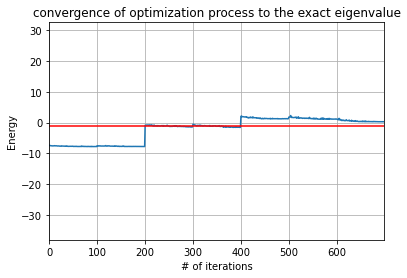

In [44]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [45]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_3_qubits, "full")

7it [00:00, 14.37it/s]
7it [00:00, 13.43it/s]
7it [00:00, 12.85it/s]
7it [00:00, 13.18it/s]
7it [00:00, 14.17it/s]
7it [00:00, 12.16it/s]
7it [00:00, 12.72it/s]
7it [00:00, 13.85it/s]
7it [00:00, 12.02it/s]
7it [00:00, 12.77it/s]
7it [00:00, 12.57it/s]
7it [00:00, 13.05it/s]
7it [00:00, 14.47it/s]
7it [00:00, 12.54it/s]
7it [00:00, 12.86it/s]
7it [00:00, 12.11it/s]
7it [00:00, 13.78it/s]
7it [00:00, 13.18it/s]
7it [00:00, 12.72it/s]
7it [00:00, 12.41it/s]
7it [00:00, 11.18it/s]
7it [00:00, 12.68it/s]
7it [00:00, 13.23it/s]
7it [00:00, 13.81it/s]
7it [00:00, 13.09it/s]
7it [00:00, 12.71it/s]
7it [00:00, 12.71it/s]
7it [00:00, 14.42it/s]
7it [00:00, 11.98it/s]
7it [00:00, 13.32it/s]
7it [00:00, 12.95it/s]
7it [00:00, 13.69it/s]
7it [00:00, 14.33it/s]
7it [00:00, 12.86it/s]
7it [00:00, 12.93it/s]
7it [00:00, 13.42it/s]
7it [00:00, 14.09it/s]
7it [00:00, 12.97it/s]
7it [00:00, 13.14it/s]
7it [00:00, 14.55it/s]
7it [00:00, 13.66it/s]
7it [00:00, 12.99it/s]
7it [00:00, 12.80it/s]
7it [00:00,

[2.37880933 2.88353228 4.3854168  5.26343685 2.71286475 3.21942899
 5.7153658  1.99958165 4.25083341 2.79425461 2.06832249 4.33877037
 4.9295546  2.46609714 0.0356497  5.99452839 6.04134223 5.07814534
 4.87514728 1.41448563 3.26197867 6.05880847 1.21245622 3.29250578]


7it [00:00, 12.89it/s]

CPU times: total: 53.8 s
Wall time: 54.8 s


[(-1.1327102067329746+0j), (-1.1089522226243493+0j), (-0.8673630797839832+0j), (-0.8433012058342556+0j), (0.5479228225821259+0j), (0.5543478038595204+0j), (1.4216636087077101+0j), (1.4283924798262082+0j)]
Exact Eigenvalue:
(-1.1327102067329746+0j)

Approximated Eigenvalue:
0.3106710508763552

Approximation Error
0.7257276847779011


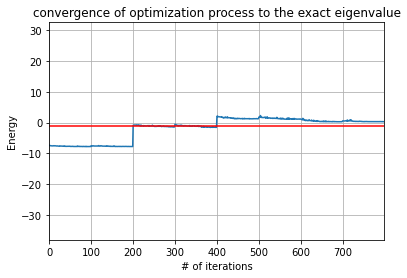

In [46]:
compare_exact_and_approximated_eigenvalue(transverse_ising_3_qubits, TI_approximated_eigenvalue)

##  Transverse Ising Model 2 qubits

In [47]:
QUBITS_NUM = 2 
N = 2**QUBITS_NUM

NUM_SHOTS = 1024
NUM_ITERATIONS = 100

CIRCUIT_DEPTH = 3
PARAMS_NUM = 2*QUBITS_NUM*(CIRCUIT_DEPTH+1)

In [48]:
transverse_ising_2_qubits = 0.13755727363376802 * (I^X) \
                            + 0.43305656297810435 * (X^I) \
                            + 0.8538597608997253 * (Z^Z)

#### Linear Entangelment

In [49]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "linear")

3it [00:00, 16.56it/s]
3it [00:00, 20.65it/s]
3it [00:00, 20.16it/s]
3it [00:00, 17.07it/s]
3it [00:00, 18.62it/s]
3it [00:00, 21.88it/s]
3it [00:00, 20.91it/s]
3it [00:00, 17.62it/s]
3it [00:00, 16.46it/s]
3it [00:00, 19.50it/s]
3it [00:00, 20.43it/s]
3it [00:00, 15.22it/s]
3it [00:00, 17.23it/s]
3it [00:00, 19.20it/s]
3it [00:00, 20.45it/s]
3it [00:00, 19.98it/s]
3it [00:00, 15.49it/s]
3it [00:00, 19.28it/s]
3it [00:00, 20.79it/s]
3it [00:00, 19.43it/s]
3it [00:00, 14.82it/s]
3it [00:00, 19.43it/s]
3it [00:00, 22.00it/s]
3it [00:00, 21.49it/s]
3it [00:00, 17.40it/s]
3it [00:00, 16.51it/s]
3it [00:00, 17.14it/s]
3it [00:00, 19.73it/s]
3it [00:00, 18.51it/s]
3it [00:00, 15.67it/s]
3it [00:00, 19.33it/s]
3it [00:00, 21.63it/s]
3it [00:00, 21.72it/s]
3it [00:00, 19.63it/s]
3it [00:00, 20.13it/s]
3it [00:00, 21.80it/s]
3it [00:00, 19.99it/s]
3it [00:00, 21.78it/s]
3it [00:00, 20.82it/s]
3it [00:00, 19.80it/s]
3it [00:00, 21.13it/s]
3it [00:00, 20.73it/s]
3it [00:00, 16.06it/s]
3it [00:00,

[3.70940039 0.07023641 5.63614769 5.78931634 3.56044473 2.86874373
 0.99142806 7.24674658 4.70994386 5.11635211 2.40755338 0.77225073
 1.16169782 4.20641447 4.36957418 6.05332665]


3it [00:00, 19.18it/s]

CPU times: total: 16.2 s
Wall time: 16.7 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.27323975521480925

Approximation Error
0.7339371592365893


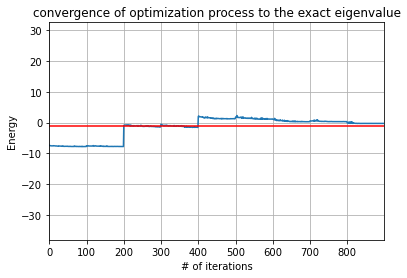

In [50]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

#### Full Entangelment

In [51]:
%%time
TI_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(transverse_ising_2_qubits, "full")

3it [00:00, 14.85it/s]
3it [00:00, 21.39it/s]
3it [00:00, 20.02it/s]
3it [00:00, 16.69it/s]
3it [00:00, 14.49it/s]
3it [00:00, 15.54it/s]
3it [00:00, 17.13it/s]
3it [00:00, 17.65it/s]
3it [00:00, 18.66it/s]
3it [00:00, 15.04it/s]
3it [00:00, 21.30it/s]
3it [00:00, 19.93it/s]
3it [00:00, 15.95it/s]
3it [00:00, 19.40it/s]
3it [00:00, 19.65it/s]
3it [00:00, 20.62it/s]
3it [00:00, 16.79it/s]
3it [00:00, 14.98it/s]
3it [00:00, 19.55it/s]
3it [00:00, 19.43it/s]
3it [00:00, 15.74it/s]
3it [00:00, 17.20it/s]
3it [00:00, 19.05it/s]
3it [00:00, 20.52it/s]
3it [00:00, 16.58it/s]
3it [00:00, 17.85it/s]
3it [00:00, 20.51it/s]
3it [00:00, 21.20it/s]
3it [00:00, 20.66it/s]
3it [00:00, 14.99it/s]
3it [00:00, 16.78it/s]
3it [00:00, 22.00it/s]
3it [00:00, 18.26it/s]
3it [00:00, 17.48it/s]
3it [00:00, 18.09it/s]
3it [00:00, 19.98it/s]
3it [00:00, 20.41it/s]
3it [00:00, 18.40it/s]
3it [00:00, 21.88it/s]
3it [00:00, 19.69it/s]
3it [00:00, 20.40it/s]
3it [00:00, 18.67it/s]
3it [00:00, 20.37it/s]
3it [00:00,

[3.50985829 5.09046256 5.54589682 6.02130931 2.56701381 5.38651796
 5.72728002 5.18236757 2.01938393 3.78072078 3.13863173 0.09950308
 2.51104582 1.71052576 4.08508188 3.00034567]


3it [00:00, 18.99it/s]

CPU times: total: 16.3 s
Wall time: 16.9 s


[(-1.0269745088446245+0j), (-0.9035465241407018+0j), (0.9035465241407012+0j), (1.0269745088446243+0j)]
Exact Eigenvalue:
(-1.0269745088446245+0j)

Approximated Eigenvalue:
-0.278242839751331

Approximation Error
0.729065485700943


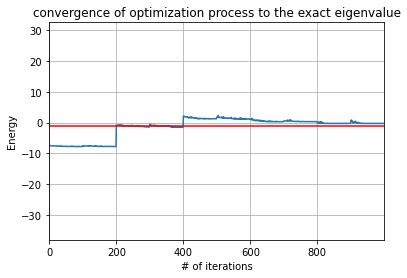

In [52]:
compare_exact_and_approximated_eigenvalue(transverse_ising_2_qubits, TI_approximated_eigenvalue)

## H2 Molecule 2 qubits

In [53]:
from qiskit.opflow import X, Z, I

H2_molecule_Hamiltonian_2_qubits = -0.5053051899926562*(I^I) + \
                            -0.3277380754984016*(Z^I) + \
                            0.15567463610622564*(Z^Z) + \
                            -0.3277380754984016*(I^Z)

#### Linear Entangelment

In [54]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "linear")

4it [00:00, 16.72it/s]
4it [00:00, 21.16it/s]
4it [00:00, 19.92it/s]
4it [00:00, 15.23it/s]
4it [00:00, 21.14it/s]
4it [00:00, 20.91it/s]
4it [00:00, 14.94it/s]
4it [00:00, 12.41it/s]
4it [00:00, 15.30it/s]
4it [00:00, 20.15it/s]
4it [00:00, 20.90it/s]
4it [00:00, 17.04it/s]
4it [00:00, 20.50it/s]
4it [00:00, 21.03it/s]
4it [00:00, 17.65it/s]
4it [00:00, 18.69it/s]
4it [00:00, 20.41it/s]
4it [00:00, 16.56it/s]
4it [00:00, 19.82it/s]
4it [00:00, 20.23it/s]
4it [00:00, 16.92it/s]
4it [00:00, 19.49it/s]
4it [00:00, 19.99it/s]
4it [00:00, 19.68it/s]
4it [00:00, 16.41it/s]
4it [00:00, 19.34it/s]
4it [00:00, 19.98it/s]
4it [00:00, 16.02it/s]
4it [00:00, 18.62it/s]
4it [00:00, 19.49it/s]
4it [00:00, 21.06it/s]
4it [00:00, 16.12it/s]
4it [00:00, 20.41it/s]
4it [00:00, 20.08it/s]
4it [00:00, 15.15it/s]
4it [00:00, 19.66it/s]
4it [00:00, 21.04it/s]
4it [00:00, 16.55it/s]
4it [00:00, 18.73it/s]
4it [00:00, 22.00it/s]
4it [00:00, 18.29it/s]
4it [00:00, 17.12it/s]
4it [00:00, 20.07it/s]
4it [00:00,

[3.22444384 5.3329272  1.05405819 2.61925244 6.12742873 5.82906007
 4.16057073 2.83183673 0.13497428 1.07134497 1.09973217 3.86216871
 3.41318508 3.18931716 3.05711916 1.72871249]


4it [00:00, 19.76it/s]

CPU times: total: 21.9 s
Wall time: 23 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9908481207540387

Approximation Error
0.014186139700313072


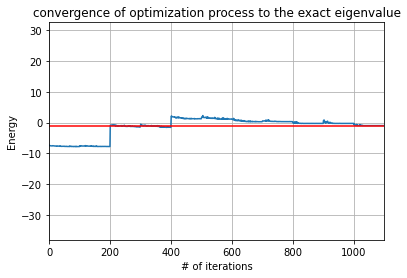

In [55]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)

#### Full Entangelment

In [56]:
%%time
H2_approximated_eigenvalue = get_approximated_eigenvalue_of_hamiltonian(H2_molecule_Hamiltonian_2_qubits, "full")

4it [00:00, 15.69it/s]
4it [00:00, 19.02it/s]
4it [00:00, 19.96it/s]
4it [00:00, 15.70it/s]
4it [00:00, 21.11it/s]
4it [00:00, 20.31it/s]
4it [00:00, 15.83it/s]
4it [00:00, 20.07it/s]
4it [00:00, 20.74it/s]
4it [00:00, 15.28it/s]
4it [00:00, 20.31it/s]
4it [00:00, 20.93it/s]
4it [00:00, 17.28it/s]
4it [00:00, 17.59it/s]
4it [00:00, 20.55it/s]
4it [00:00, 17.07it/s]
4it [00:00, 18.10it/s]
4it [00:00, 20.69it/s]
4it [00:00, 20.67it/s]
4it [00:00, 16.35it/s]
4it [00:00, 19.82it/s]
4it [00:00, 20.15it/s]
4it [00:00, 15.93it/s]
4it [00:00, 17.77it/s]
4it [00:00, 17.77it/s]
4it [00:00, 12.07it/s]
4it [00:00, 19.29it/s]
4it [00:00, 21.81it/s]
4it [00:00, 16.22it/s]
4it [00:00, 20.08it/s]
4it [00:00, 21.72it/s]
4it [00:00, 15.96it/s]
4it [00:00, 22.11it/s]
4it [00:00, 20.26it/s]
4it [00:00, 15.18it/s]
4it [00:00, 20.58it/s]
4it [00:00, 20.78it/s]
4it [00:00, 15.18it/s]
4it [00:00, 21.56it/s]
4it [00:00, 19.98it/s]
4it [00:00, 14.53it/s]
4it [00:00, 17.80it/s]
4it [00:00, 15.97it/s]
4it [00:00,

[3.89665037 5.50940614 6.29554508 1.53025156 3.47708332 6.0467287
 5.8049935  5.27904654 2.63628117 4.30615833 6.52416906 2.26229053
 3.64837286 2.55749111 2.83908531 2.65350955]


4it [00:00, 16.40it/s]

CPU times: total: 22.1 s
Wall time: 22.8 s


[(-1.0051067048832336+0j), (-0.6609798260988818+0j), (-0.6609798260988818+0j), (0.30584559711037274+0j)]
Exact Eigenvalue:
(-1.0051067048832336+0j)

Approximated Eigenvalue:
-0.9995537079042548

Approximation Error
0.005524783539896819


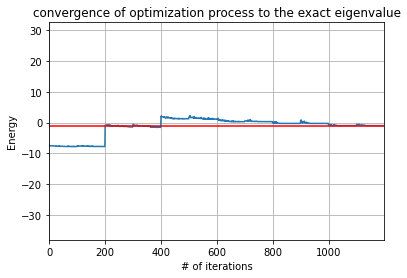

In [57]:
compare_exact_and_approximated_eigenvalue(H2_molecule_Hamiltonian_2_qubits, H2_approximated_eigenvalue)